# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file   = './../traffic-signs-data/train.p'
validation_file = './../traffic-signs-data/valid.p'
testing_file    = './../traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES** 

In [2]:
import numpy as np

n_train = len(X_train)

n_validation = len(X_valid)

n_test = len(X_test)

image_shape = X_train.shape[1:]

n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


The German Road Sign Dataset includes almost 52,000 images representing 43 different signs (i.e. classes).
Training dataset contains almost 67% of the images
Validation dataset contains 8.5%
Testing dataset contains 24.5%

All images are 32*32 pixels in RGB format.

### Include an exploratory visualization of the dataset

In [3]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def pltImages(images, labels, nrows = 1, ncols = 2, fig_w = 20, fig_h = 10, isgray = False):
    #below code is inspired from https://stackoverflow.com/questions/17111525/how-to-show-multiple-images-in-one-figure
    assert len(images) == len(labels)
    assert len(images) <= (nrows * ncols)
    
    fig = plt.figure(figsize=(fig_w, fig_h))
    
    for index in range(len(images)):
        plot = fig.add_subplot(nrows,ncols,index+1)
        plot.set_title(labels[index])
        if(isgray == False):
            plt.imshow(images[index].squeeze())
        else:
            plt.imshow(images[index].squeeze(), cmap='gray')
    
    plt.show()

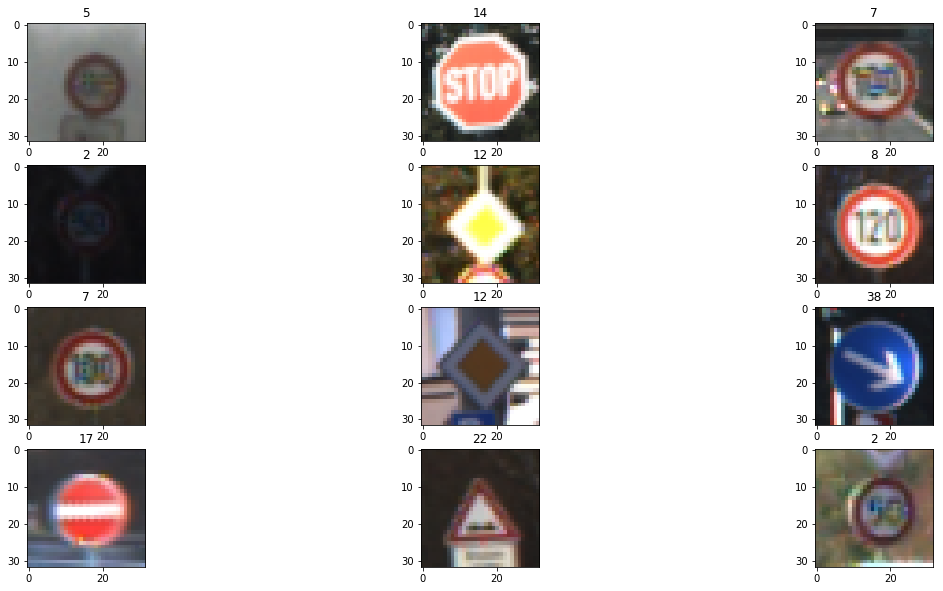

In [5]:
vis_imgs   = []
vis_labels = []

#show 12 random images from training dataset
for i in range(12):
    index = random.randint(0, len(X_train))
    vis_imgs.append(X_train[index])
    vis_labels.append(y_train[index])

pltImages(vis_imgs, vis_labels, 4, 3)

From Images above it is clear that the dataset have a large variance in lighting, rotation, exposure, etc.. chractristics so it can be used with no needed augmentation of the dataset as suggested in the rubric.

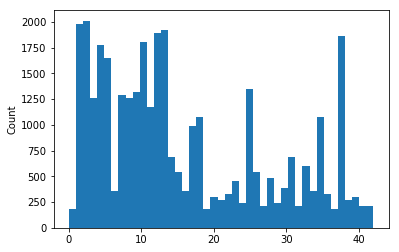

In [6]:
#code below is inspired from
#https://stackoverflow.com/questions/33203645/how-to-plot-a-histogram-using-matplotlib-in-python-with-a-list-of-data

plt.hist(y_train, bins=n_classes)
plt.ylabel('Count');

From above histogram it is clear the the frequency of the images is not consistent across all classes this can lead to the network inbalace, i.e. learn some image classes better that others.

Having a small batch size and shuffling the data set before each epoch solved this issue as the frequency should be very close to uniform in a shuffled small set.

A better solution as described in the rubric would be to augment some of the low occuring image classes to generate fake data that can be used to balance the network training.

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set

In [7]:
import cv2
from sklearn import preprocessing
from sklearn.utils import shuffle

In [8]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

#below code is inspired from https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
def HistogramEqualization(img):
    return  cv2.equalizeHist(img)

def HistogramEqualization2(img, cl=2.0, gridsize=(8,8)):
    clahe = cv2.createCLAHE(clipLimit=cl, tileGridSize=gridsize)
    return clahe.apply(img)

#using the suggested normalization functions lead to poor results and resulting
#images had a mean value far from 0, around 1.3 in my tests
def normalize(img):
    return (img - 128) / 128

#Code below inspired from 
#https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/
#with this normalization function the output is around 0.16
def normalize2(img):
    return preprocessing.normalize(img)

#Code below inspired from 
#https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/
#with both normalize2 and standardize applied together the mean is 
#basically zero as required, calculated value for visualation set shown below.
def Standardize(img):
    return preprocessing.scale(img)

In [9]:
def preProcess(x_in, x_out):
    for im in x_in:
        #sharpen the image
        blurred = gaussian_blur(im, 3)
        sharpned = weighted_img(blurred, im, α=2, β=-1)
        #convert to gray scale
        gray = grayscale(sharpned)
        #normalize data, i.e. rescale to 0-1 range
        normalized = normalize2(gray)
        #standardize data, i.e. shift data distribution to have 0 mean and unit
        #variance
        standardized = Standardize(normalized)
        x_out.append(standardized.reshape((32,32,1)))

Looking at the random set visualized above it is clear that the edges in the images are very rough and close to each other, sharpening the image would generate a more clear image.
Also downsize the image to grayscale would help in recreasing the computational bandwidth needed for nerual network calculations.

C:\Miniconda3\envs\gpu_env\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


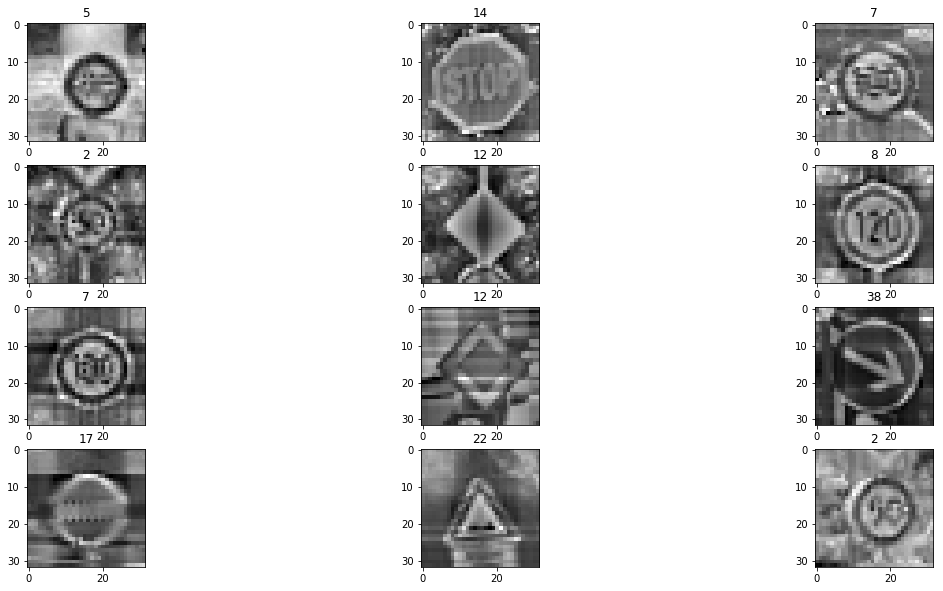

In [10]:
pvis_imgs   = []

#show effect of the preprocessing on the above visualized images.
preProcess(vis_imgs, pvis_imgs)

pltImages(pvis_imgs, vis_labels, 4, 3, isgray=True)

The above images appear to be good however it is noticed that that brightness across image regions is not consistent, using histogram equalization would result in having a uniform brightness across all image

In [11]:
def preProcess2(x_in, x_out):
    for im in x_in:
        #sharpen the image
        blurred = gaussian_blur(im, 3)
        sharpned = weighted_img(blurred, im, α=1, β=-0.5)
        #convert to gray scale
        gray = grayscale(sharpned)
        #perform histogram equalization
        hist = HistogramEqualization2(gray, 2, (4,4))
        #normalize data, i.e. rescale to 0-1 range
        normalized = normalize2(hist)
        #standardize data, i.e. shift data distribution to have 0 mean and unit
        #variance
        #standardized = Standardize(normalized)
        x_out.append(normalized.reshape((32,32,1)))

C:\Miniconda3\envs\gpu_env\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


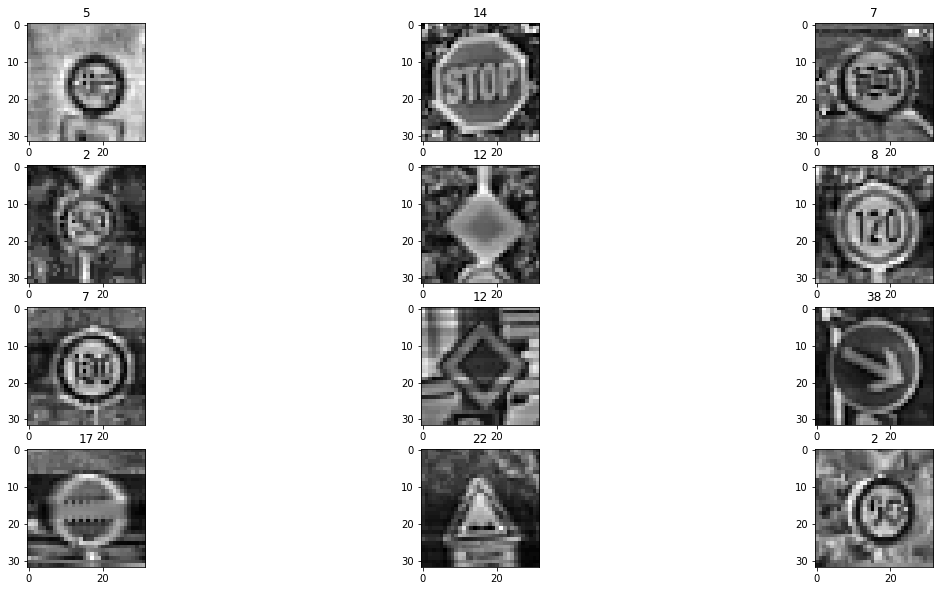

In [12]:
pvis_imgs   = []

#show effect of the preprocessing on the above visualized images.
preProcess2(vis_imgs, pvis_imgs)

pltImages(pvis_imgs, vis_labels, 4, 3, isgray=True)

In [13]:
print(np.mean(vis_imgs))
print(np.mean(pvis_imgs))

92.6429307726
0.15937731407


As shown for the sample set the mean is basically zero so we can apply for the rest of the training, validation and testing sets.

In [14]:
#preshuffle data to make sure dataset is randomized
X_train, y_train = shuffle(X_train, y_train)
X_valid, y_valid = shuffle(X_valid, y_valid)
X_test, y_test  = shuffle(X_test, y_test)

In [15]:
pX_train = []
pX_valid = []
pX_test  = []

preProcess2(X_train, pX_train)
preProcess2(X_valid, pX_valid)
preProcess2(X_test, pX_test)

C:\Miniconda3\envs\gpu_env\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


Making Sure that we have not affected dataset properties by comparing with the previously calculated above.

In [16]:
n_train = len(pX_train)
n_validation = len(pX_valid)
n_test = len(pX_test)
image_shape = pX_train[0].shape

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 1)


All values agree with previously calculated values except for image shape as it was converted to gray scale during preprocessing so the 3 color channel is converted to a single gray channel

### Model Architecture

In [17]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten

In [18]:
EPOCHS = 50
rate = 0.0008
#decrease batch size to address issue of the inconsistent image classes frequency
BATCH_SIZE = 96
keepprob = 0.5  # Dropout, probability to keep units

In [19]:
def conv2d(x, W, b, s=1):
    x = tf.nn.conv2d(x, W, strides=[1, s, s, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], 
                          padding='VALID')

In [20]:
# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1

I started using Original Lenet but found that it never excedded 0.92 regardless of training parameters tuning, preprocessing, etc..
I had a threory that increasing the number of features should allow the network to have a better representation of the dataset.
Testing it out it worked out and the modified LeNet architecture is as below.

I have also added a new Fully connected layer to make sure that the relative size deifference between layers is preserved.

In [21]:
def LeNet_mod(x):
    
    #Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x16.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 16), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(16))
    conv1   = conv2d(x, conv1_W, conv1_b, 1)

    #Activation.
    conv1 = tf.nn.relu(conv1)

    #Pooling. Input = 28x28x16. Output = 14x14x16.
    conv1 = maxpool2d(conv1, 2)

    #Layer 2: Convolutional. Output = 10x10x64.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 64), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2   = conv2d(conv1, conv2_W, conv2_b, 1)
    
    #Activation.
    conv2 = tf.nn.relu(conv2)

    #Pooling. Input = 10x10x64. Output = 5x5x64.
    conv2 = maxpool2d(conv2, 2)

    #Flatten. Input = 5x5x64. Output = 1600.
    fc0   = flatten(conv2)
    
    #Layer 3: Fully Connected. Input = 1600. Output = 540.
    fcA_W = tf.Variable(tf.truncated_normal(shape=(1600, 540), mean = mu, stddev = sigma))
    fcA_b = tf.Variable(tf.zeros(540))
    fcA   = tf.matmul(fc0, fcA_W) + fcA_b
    
    #Activation.
    fcA    = tf.nn.relu(fcA)
    
    fcA_d = tf.nn.dropout(fcA, keepprob)
    
    #Layer 4: Fully Connected. Input = 540. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(540, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fcA_d, fc1_W) + fc1_b
    
    #Activation.
    fc1    = tf.nn.relu(fc1)
    
    fc1_d = tf.nn.dropout(fc1, keepprob)

    #Layer 5: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1_d, fc2_W) + fc2_b
    
    #Activation.
    fc2    = tf.nn.relu(fc2)
    
    fc2_d = tf.nn.dropout(fc2, keepprob)

    #Layer 6: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2_d, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

In [22]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [23]:
logits = LeNet_mod(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, 
                                                        logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [24]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [25]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [26]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(pX_train)
    
    ValidAccuracy = []
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        #shuffle data to ensure randomness
        pX_train, y_train = shuffle(pX_train, y_train)
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = pX_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(pX_valid, y_valid)
        
        ValidAccuracy.append(validation_accuracy)
        
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.481

EPOCH 2 ...
Validation Accuracy = 0.707

EPOCH 3 ...
Validation Accuracy = 0.798

EPOCH 4 ...
Validation Accuracy = 0.854

EPOCH 5 ...
Validation Accuracy = 0.880

EPOCH 6 ...
Validation Accuracy = 0.894

EPOCH 7 ...
Validation Accuracy = 0.911

EPOCH 8 ...
Validation Accuracy = 0.919

EPOCH 9 ...
Validation Accuracy = 0.923

EPOCH 10 ...
Validation Accuracy = 0.932

EPOCH 11 ...
Validation Accuracy = 0.933

EPOCH 12 ...
Validation Accuracy = 0.931

EPOCH 13 ...
Validation Accuracy = 0.948

EPOCH 14 ...
Validation Accuracy = 0.943

EPOCH 15 ...
Validation Accuracy = 0.941

EPOCH 16 ...
Validation Accuracy = 0.944

EPOCH 17 ...
Validation Accuracy = 0.954

EPOCH 18 ...
Validation Accuracy = 0.949

EPOCH 19 ...
Validation Accuracy = 0.953

EPOCH 20 ...
Validation Accuracy = 0.951

EPOCH 21 ...
Validation Accuracy = 0.948

EPOCH 22 ...
Validation Accuracy = 0.954

EPOCH 23 ...
Validation Accuracy = 0.953

EPOCH 24 ...
Validation Accura

Plot the Model accuracy progression

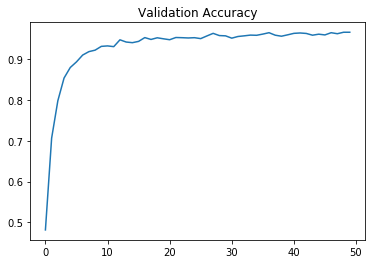

In [27]:
plt.plot(ValidAccuracy)
plt.title("Validation Accuracy")
plt.show()

Run Aganist Test portion

In [29]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./lenet.meta')
    saver2.restore(sess, "./lenet")
    test_accuracy = evaluate(pX_test, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Set Accuracy = 0.947


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [30]:
import os
import matplotlib.image as mpimg

In [41]:
myimages = []
mylabels = []

images = os.listdir("mySigns/")

This image 1.png is: <class 'numpy.ndarray'> with dimensions: (32, 32, 3)
This image 19.png is: <class 'numpy.ndarray'> with dimensions: (32, 32, 3)
This image 22.png is: <class 'numpy.ndarray'> with dimensions: (32, 32, 3)
This image 27.png is: <class 'numpy.ndarray'> with dimensions: (32, 32, 3)
This image 3.png is: <class 'numpy.ndarray'> with dimensions: (32, 32, 3)
This image 31.png is: <class 'numpy.ndarray'> with dimensions: (32, 32, 3)
This image 36.png is: <class 'numpy.ndarray'> with dimensions: (32, 32, 3)
This image 4.png is: <class 'numpy.ndarray'> with dimensions: (32, 32, 3)
This image 9.png is: <class 'numpy.ndarray'> with dimensions: (32, 32, 3)


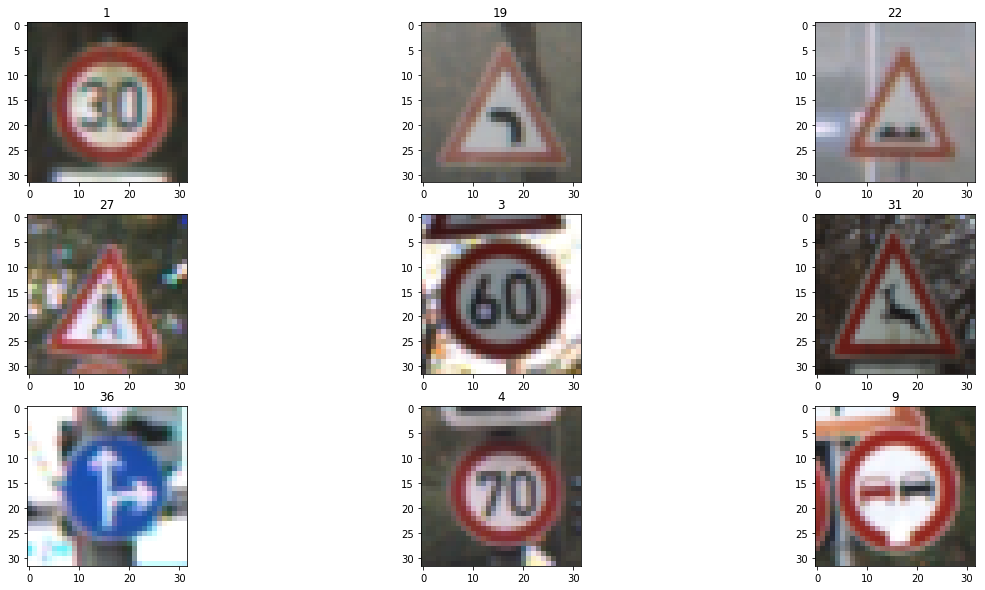

In [42]:
for image in images:
        im = cv2.imread("mySigns/" + image)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        print('This image' , image , 'is:', type(im), 'with dimensions:', im.shape)
        myimages.append(im)
        mylabels.append(image.split('.')[0])
      
pltImages(myimages, mylabels, 3, 3, isgray=False)

From above representation the images are very clear and almost centered in the middle of the image, it should be very easy for the network to classify them correctly

In [43]:
pmyimages = []

preProcess2(myimages, pmyimages)

C:\Miniconda3\envs\gpu_env\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


### Predict the Sign Type for Each Image

In [44]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./lenet.meta')
    saver2.restore(sess, "./lenet")
    test_accuracy = evaluate(pmyimages, mylabels)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Set Accuracy = 1.000


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [46]:
softmax = tf.nn.softmax(logits)
top_k   = tf.nn.top_k(softmax, k=3)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./lenet.meta')
    saver2.restore(sess, "./lenet")
    values, indices = sess.run(top_k, feed_dict={x: pmyimages})
    print(values, indices)

INFO:tensorflow:Restoring parameters from ./lenet
[[  1.00000000e+00   2.61688313e-20   1.50951079e-29]
 [  9.99874949e-01   7.38972012e-05   3.93763330e-05]
 [  9.99266207e-01   6.77393517e-04   5.31031728e-05]
 [  9.99982476e-01   1.67663584e-05   6.22267066e-07]
 [  1.00000000e+00   7.80458317e-21   1.61340155e-21]
 [  1.00000000e+00   1.36501444e-11   1.58812563e-16]
 [  1.00000000e+00   3.70373177e-16   3.65268979e-22]
 [  1.00000000e+00   1.48749080e-23   2.13512481e-24]
 [  1.00000000e+00   7.49082929e-30   1.05794797e-31]] [[ 1 14 11]
 [19  3 29]
 [22 25 29]
 [27 18 24]
 [ 3 19  9]
 [31 29 25]
 [36 25  0]
 [ 4  7  5]
 [ 9 15 10]]


As expected due to the very clear, centered, bright images, the neural network had no issues in confirming the output of those images. This can be seen as for nearly all the images the confidence was almost 100% for the correct class.

This is of course not realistic as it is not expected to have such clear images as a normal input.